In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 1
NUM_WORKERS = 8
NOISE_SCALE = 20
NUM_INTERPOLATES = 10


DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


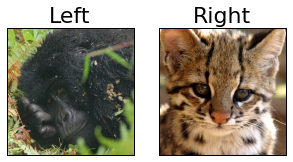

In [5]:
# Get random endpoints 
def get_samples(it):
    _, (im_s, _) = next(it)
    with ch.no_grad():
        (_, rep_s), _ = model(im_s.cuda(), with_latent=True)
    return im_s, rep_s.detach()

im_l, rep_l = get_samples(data_iterator)  # Left endpoint
im_r, rep_r = get_samples(data_iterator)  # Right endpoint

show_image_column([im_l, im_r], ['Left', 'Right'], fontsize=22)

In [6]:
# Define seed image and representations for interpolation
# For each interpolate, the seed image is obtained using linear interpolation between endpoints in image space and
# representation to match is obtained using linear interpolation between endpoints in representation space

img_seed = ch.zeros_like(im_l).repeat(NUM_INTERPOLATES, 1, 1, 1) 
rep_match = ch.zeros_like(rep_l).repeat(NUM_INTERPOLATES, 1)

for j in range(NUM_INTERPOLATES):
    f = 1.0 * j/(NUM_INTERPOLATES-1)
    rep_match[j] = (1 - f) * rep_l[0, ...] + f * rep_r[0, ...]
    img_seed[j] = (1 - f) * im_l[0, ...] + f * im_r[0, ...] 

In [7]:
# Custom loss for inversion
def inversion_loss(model, inp, targ):
    _, rep = model(inp, with_latent=True, fake_relu=True)
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss, None

In [8]:
# PGD Parameters
kwargs = {
    'criterion': ch.nn.CrossEntropyLoss(),
    'custom_loss': inversion_loss,
    'constraint':'2',
    'eps': 1000,
    'step_size': 0.1 if DATA =='CIFAR' else 1,
    'iterations': 10000, 
    'do_tqdm': True,
    'targeted': True
}

In [9]:
# Interpolate images by inverting linear interpolations of representations of the two endpoints
_, img_interpolation = model(img_seed, rep_match, make_adv=True, **kwargs)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

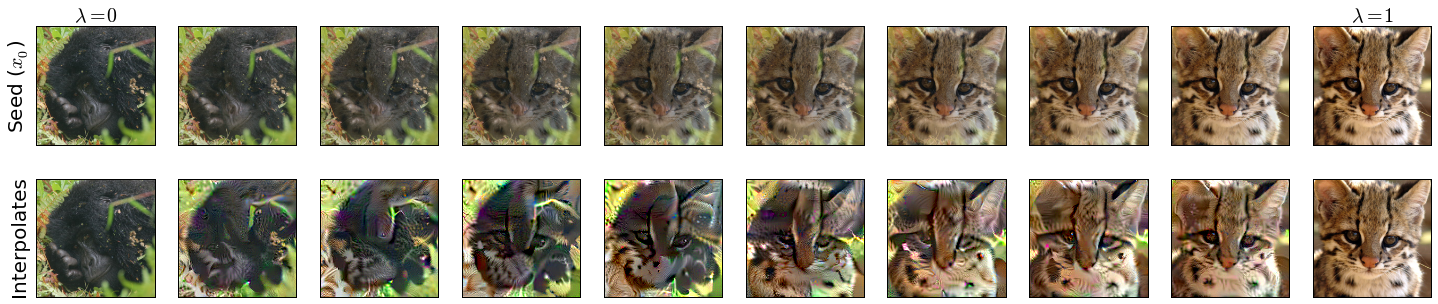

In [10]:
# Visualization of latent-space interpolation
show_image_row([img_seed.cpu(), img_interpolation.detach().cpu()],
               [r'Seed ($x_0$)', 'Interpolates'],
               tlist=[[r'$\lambda=0$'] + [""] * (NUM_INTERPOLATES - 2) + [r'$\lambda=1$'],
                      [""] * NUM_INTERPOLATES],
               fontsize=20)